# Read Netcdf data

In [1]:
import xarray as xr
import torch
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm, trange
from models import DiT_models

/p/project1/training2533/lancelin1/WeGenDiffusion/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = "/p/project1/training2533/patnala1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc"

In [3]:
ds = xr.open_dataset(data_path)

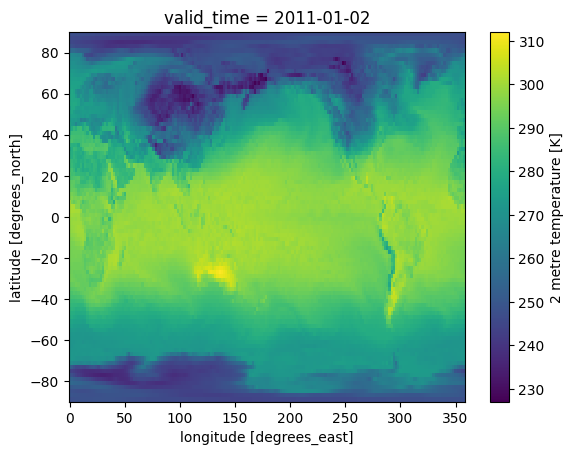

In [4]:
ds['t2m'].isel(valid_time=4).plot()

In [5]:
plt.savefig("sample_fig.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

# Forward process
Iteratively adding Gaussian noise   

One step method to emulate multiple timesteps at once

In [6]:
from diffusion import create_diffusion

In [7]:
diffusion = create_diffusion(timestep_respacing="")

In [8]:
sample_map = torch.from_numpy((ds['t2m'].isel(valid_time=4).values - ds.mean()['t2m'].values)/ds.std()['t2m'].values)

In [9]:
samples = []
for i in range(0, 1000, 50):
    timestep = torch.tensor(i, dtype=torch.long).to(sample_map.device)
    samples.append(xr.Dataset({
    "t2m": (("lat", "lon"), (diffusion.q_sample(sample_map, timestep) * ds.std()['t2m'].values) + ds.mean()['t2m'].values )
    },
    coords={
        'lat':ds['lat'],
         'lon':ds['lon']}))

/tmp/ipykernel_2238914/75973822.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  "t2m": (("lat", "lon"), (diffusion.q_sample(sample_map, timestep) * ds.std()['t2m'].values) + ds.mean()['t2m'].values )
/tmp/ipykernel_2238914/75973822.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  "t2m": (("lat", "lon"), (diffusion.q_sample(sample_map, timestep) * ds.std()['t2m'].values) + ds.mean()['t2m'].values )
/tmp/ipykernel_2238914/75973822.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  "t2m": (("lat", "lon"), (diffusion.q_sample(sample_map, timestep) * ds.std()['t2m'].values) + ds.mean()['t2m'].values )
/tmp/ipykernel_2238914/75973822.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar a

In [10]:
len(samples),samples[0]['t2m'].shape

(20, (90, 180))

In [11]:
combined = xr.concat(samples,dim="samples")

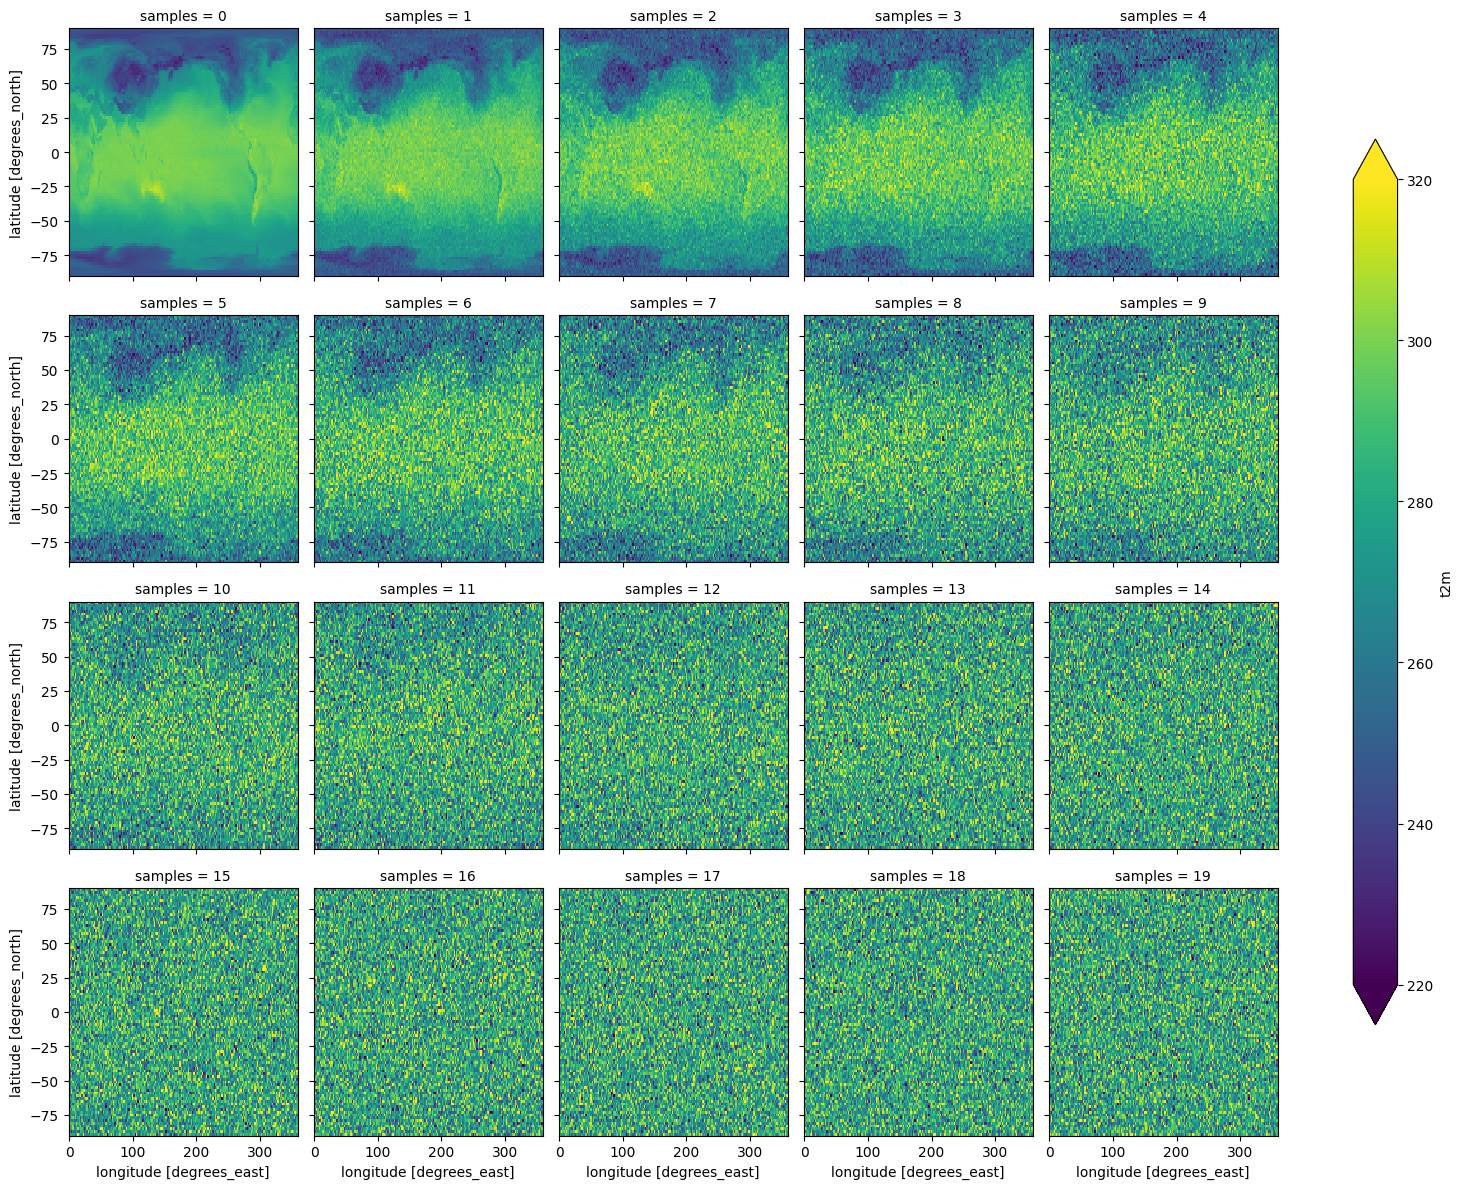

In [12]:
combined["t2m"].plot(
    col="samples",
    col_wrap=5,
    cmap="viridis",
    cbar_kwargs={
        "orientation": "vertical",   # vertical colorbar at the side
        "pad": 0.05,                  # distance from the plots
        "shrink": 0.8                  # shrink length
    },
    vmin=220,
    vmax=320
)
plt.savefig("forward_process.png")

# Reverse process
Remove noise iteratively

In [13]:
model_path = "./results/DiT-B-2_old/ckpt_0000240.pt"

In [14]:
model_state_dict = torch.load(model_path, map_location='cuda')['model']

In [15]:
model = DiT_models['DiT-B/2'](input_size=(90,180),num_classes=1000).to('cuda')

In [16]:
model.load_state_dict(model_state_dict,strict=True)

<All keys matched successfully>

In [17]:
model.eval()

DiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=768, bias=True)
      (1): SiLU()
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1001, 768)
  )
  (blocks): ModuleList(
    (0-11): 12 x DiTBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Line

In [18]:
diffusion = create_diffusion(timestep_respacing="")

In [19]:
shape = (1,1,90,180)
y = torch.zeros_like(torch.Tensor(shape[0]),dtype=torch.long,device='cuda')

In [20]:
denoised_images = diffusion.p_sample_loop_progressive(model,shape,model_kwargs=dict(y=y))

In [22]:
xarray_images = []
for idx,denoised_image in tqdm(enumerate(denoised_images)):
    if (idx+1)%50 == 0:
        xarray_images.append(torch.squeeze(denoised_image["sample"]))

1000it [02:37,  6.34it/s]


In [23]:
mean = ds.mean()['t2m'].values
std = ds.std()['t2m'].values

In [24]:
samples = []
for i in range(20):
    samples.append(xr.Dataset({
    "t2m": (("lat", "lon"), mean + std*xarray_images[i].cpu().numpy())
    },
    coords={
        'lon':ds['lon'],
         'lat':ds['lat']}))
    

In [25]:
combined = xr.concat(samples,dim="samples")

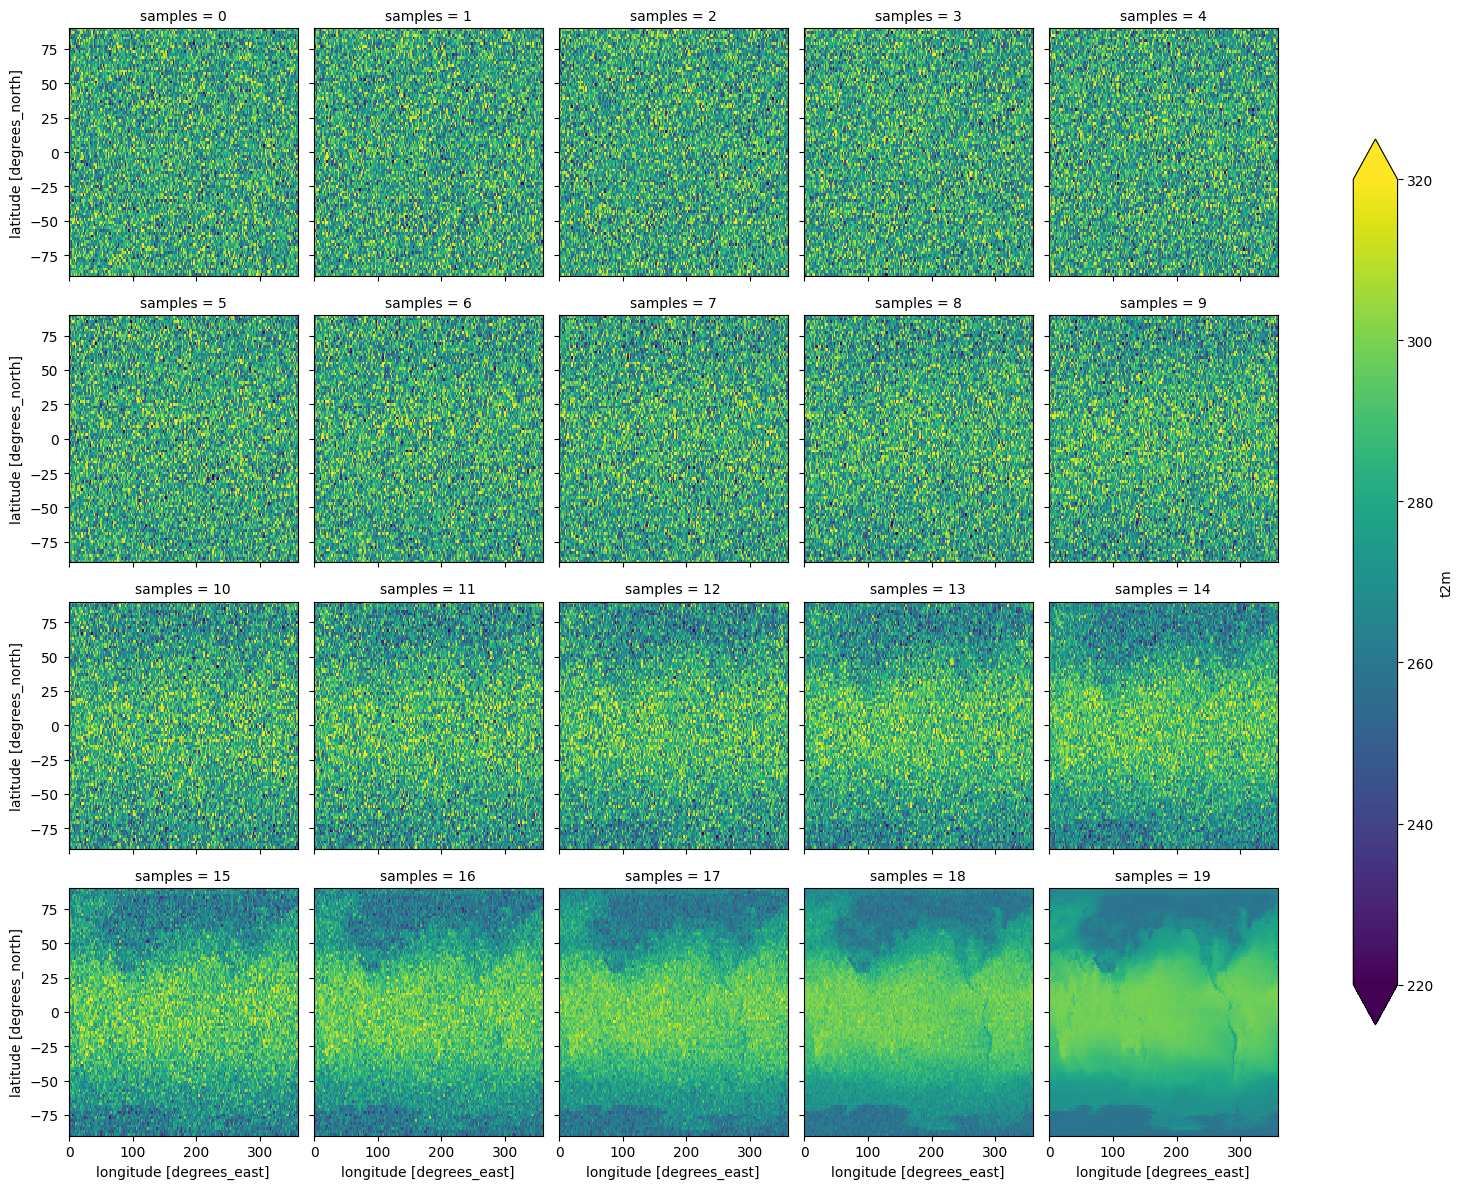

In [26]:
combined["t2m"].plot(
    col="samples",
    col_wrap=5,
    cmap="viridis",
    cbar_kwargs={
        "orientation": "vertical",   # vertical colorbar at the side
        "pad": 0.05,                  # distance from the plots
        "shrink": 0.8                  # shrink length
    },
    vmin=220,
    vmax=320
)
plt.savefig("reverse_process.png")

# Perso: Diagnose model